### Importing libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib as plt
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

### Device Selection

In [9]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

### Downloading Stock Price Data

In [10]:
ticker = 'NVDA'
df = yf.download(ticker, '2020-01-01')

[*********************100%***********************]  1 of 1 completed


This code downloads historical stock price data for NVIDIA (NVDA) starting from 2020 using Yahoo Finance.


### Stock Price Data


In [11]:
df

Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2020-01-02,5.971078,5.971078,5.891683,5.942207,237536000
2020-01-03,5.875505,5.919309,5.826474,5.851363,205384000
2020-01-06,5.900146,5.905373,5.756040,5.782173,262636000
2020-01-07,5.971576,6.017371,5.883469,5.928518,314856000
2020-01-08,5.982776,6.024091,5.927274,5.967345,277108000
...,...,...,...,...,...
2025-12-19,180.990005,181.449997,176.339996,176.669998,324925900
2025-12-22,183.690002,184.160004,182.350006,183.919998,129064400


**Open:** The price of the stock when the market opened that day <br><br>
**High:**	The highest price the stock reached during that day <br><br>
**Low:**	The lowest price the stock reached during that day <br><br>
**Close:**	The final price when the market closed (most commonly used price)<br><br>
**Volume:**	The number of shares traded during that day

### Closing Price Over Time


<Axes: xlabel='Date'>

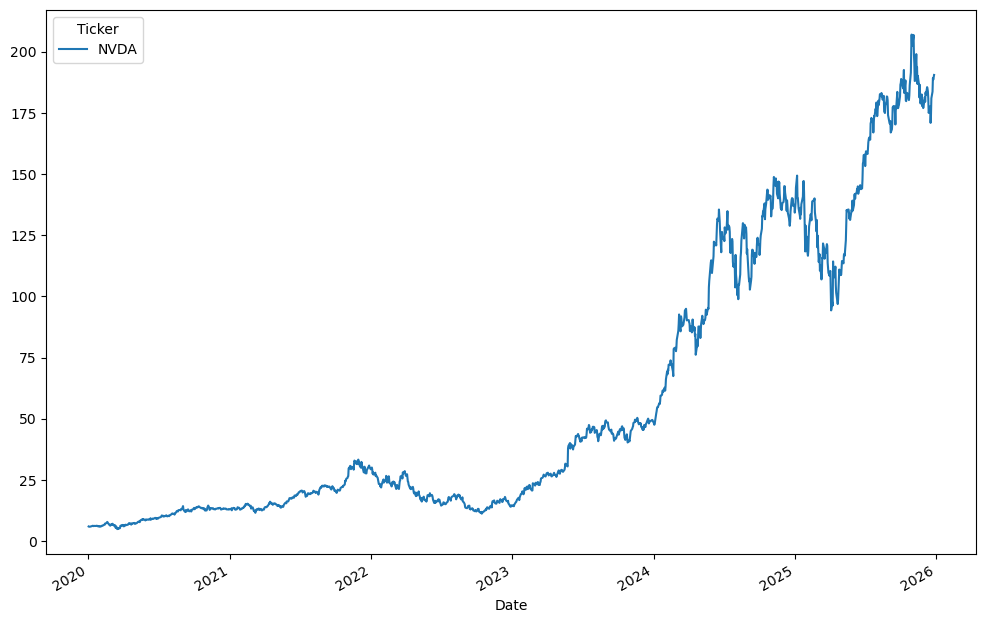

In [12]:
df.Close.plot(figsize=(12,8))

### Standardizing the Data

In [13]:
# Standardize feature by fitting the scaler and transforming the data
scaler = StandardScaler()
df['Close'] = scaler.fit_transform(df['Close'])

In [14]:
df.Close

Ticker,NVDA
Date,
2020-01-02,-0.910477
2020-01-03,-0.912172
2020-01-06,-0.911735
2020-01-07,-0.910469
2020-01-08,-0.910270
...,...
2025-12-19,2.193068
2025-12-22,2.240946
2025-12-23,2.338830


### Generating Time Series Sequences

In [15]:
seq_length = 30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

### Splitting Data into Training and Testing Sets

In [16]:
train_size = int(0.8*len(data))

X_train = torch.from_numpy(data[:train_size, :-1, :]).type(torch.Tensor).to(device)
Y_train = torch.from_numpy(data[:train_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1, :]).type(torch.Tensor).to(device)
Y_test = torch.from_numpy(data[train_size:, -1, :]).type(torch.Tensor).to(device)

### Defining the LSTM Model

In [17]:
class PredictionModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device=device)

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

This class defines an LSTM-based neural network used to predict future values from sequential data.


### Creating the LSTM Model


In [18]:
model = PredictionModel(input_dim=1, hidden_dim=32, num_layers=2, output_dim=1).to(device)

### Defining the Loss Function and Optimizer

In [19]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

### Training the Model


In [20]:
num_epochs = 200

for i in range(num_epochs):
    Y_train_pred = model(X_train)

    loss = criterion(Y_train_pred, Y_train)

    if i%25 == 0:
        print(i, loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

0 0.6261398792266846
25 0.026554344221949577
50 0.0026998529210686684
75 0.0016530799912288785
100 0.0013886889209970832
125 0.0013012817362323403
150 0.0012479405850172043
175 0.001203081221319735


### Evaluating the Model


In [21]:
model.eval()

Y_test_pred = model(X_test)

Y_train_pred = scaler.inverse_transform(Y_train_pred.detach().cpu().numpy())
Y_train = scaler.inverse_transform(Y_train.detach().cpu().numpy())
Y_test_pred = scaler.inverse_transform(Y_test_pred.detach().cpu().numpy())
Y_test = scaler.inverse_transform(Y_test.detach().cpu().numpy())

### Calculating Model Performance (RMSE)

In [22]:
train_rmse = root_mean_squared_error(Y_train[:, 0], Y_train_pred[:, 0])
test_rmse = root_mean_squared_error(Y_test[:, 0], Y_test_pred[:, 0])

### Training RMSE

In [23]:
train_rmse

1.922548770904541

### Testing RMSE

In [24]:
test_rmse

8.534244537353516

### Visualizing Predictions and Errors


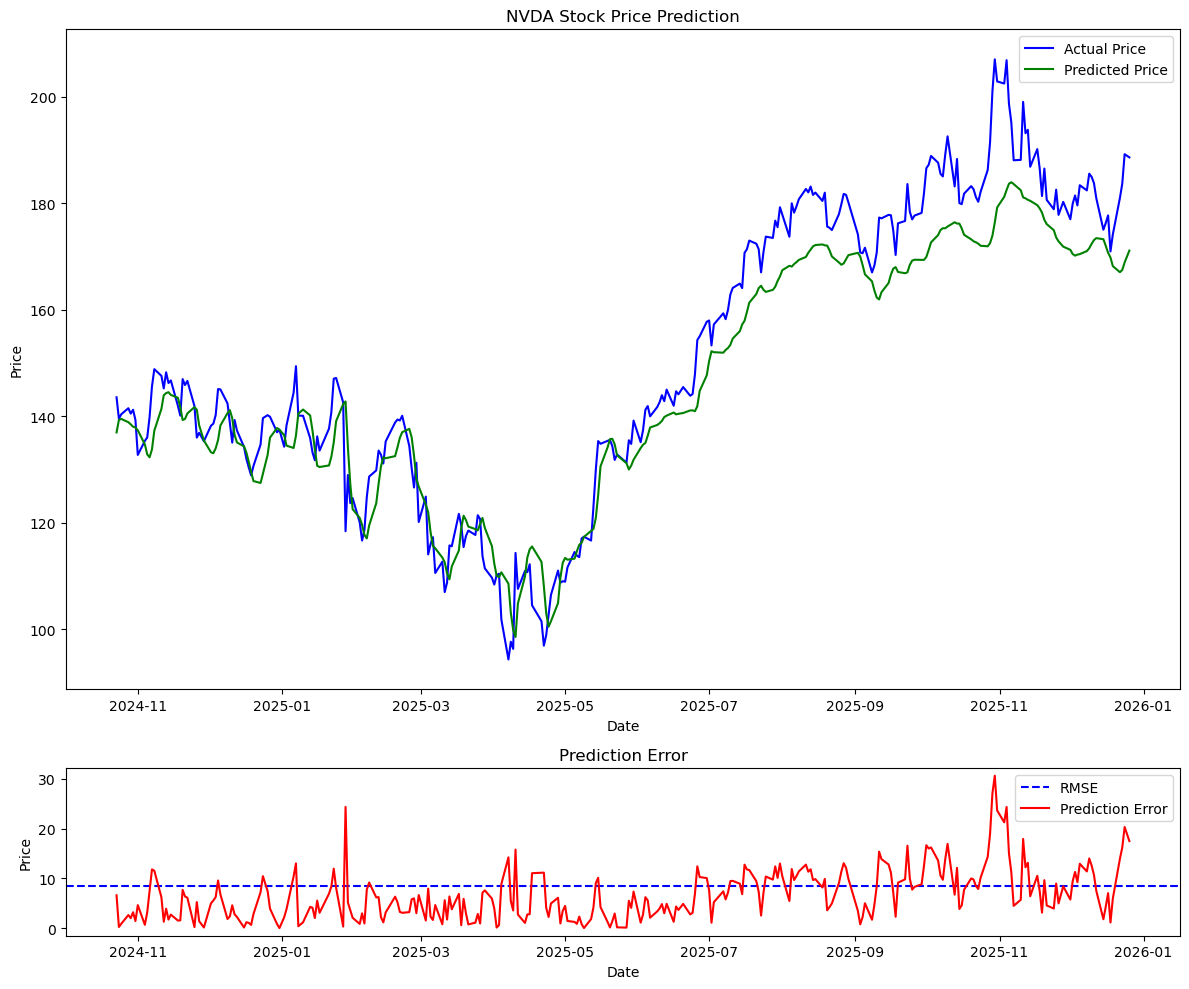

In [25]:
fig = plt.figure(figsize=(12,10))

gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(df.iloc[-len(Y_test):]. index, Y_test, color = 'blue', label = 'Actual Price')
ax1.plot(df.iloc[-len(Y_test):].index, Y_test_pred, color = 'green', label = 'Predicted Price')
ax1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

ax2 = fig.add_subplot(gs[3, 0])
ax2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
ax2.plot(df[-len(Y_test):].index, abs(Y_test-Y_test_pred), 'r', label='Prediction Error')
ax2.legend()
plt.title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Price')

plt.tight_layout()
plt.show()


### Interpretation of Results

Although the predicted prices appear to follow the general trend of the actual stock prices, the model is not truly forecasting future movements. Instead, it is largely learning to replicate recent past values, which makes the predictions look reasonable while offering limited real predictive power.

This behaviour is common in time-series models trained on highly autocorrelated data such as stock prices. The model relies heavily on previous values, causing it to lag behind sudden market changes.

The error plot further highlights this limitation:
- Prediction errors increase during periods of high volatility.
- The model struggles to respond to rapid price movements.
- The relatively consistent RMSE indicates that the model does not significantly improve its predictions over time.

Overall, while the model captures the general trend of the stock price, it fails to accurately anticipate future price movements, suggesting that more advanced features or modeling techniques are needed for better performance.
